## How to Run

1. Run cell 1. This contains the function necessary to run the preprocessing.
2. Run cell 2. This cell contains the functions necessary to do the predictions. Make sure the models are stored in the *models* folder along with the notebook
3. In cell 3, include the path to the ID and run the cell.

Define the functions

In [29]:
import cv2
import numpy as np
from imutils.object_detection import non_max_suppression
import matplotlib.pyplot as plt
import itertools


def load_and_crop_image(path):
    """
    Load an image from a file and perform image processing to detect the largest contour in the image,
    which is assumed to be the ID card in the image. Then, return the original image with a rectangle
    drawn around the ID card and the coordinates of the bounding box around the contour.

    Parameters
    ----------
    path : str
        The path to the image file.

    Returns
    -------
    tuple
        A tuple containing the original image with a rectangle drawn around the ID card and the coordinates
        of the bounding box around the contour. The first element of the tuple is the image and the second element
        is a tuple of four integers representing the x and y coordinates of the top-left corner of the bounding box,
        as well as the width and height of the bounding box.

    """
    # Load the image
    image = cv2.imread(path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny edge detection to find edges
    edges = cv2.Canny(blur, 50, 200)

    # Find contours in the edges image
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)



    # Get the contour with the largest area (assuming it is the ID card)
    mx = (0,0,0,0)      # biggest bounding box so far
    mx_area = 0
    for cont in contours:
        x,y,w,h = cv2.boundingRect(cont)
        area = w*h
        if area > mx_area:
            mx = x,y,w,h
            mx_area = area
    x,y,w,h = mx



    # Get the coordinates of the bounding box around the contour
    image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return image, (x,y,w,h)


def extract_text_boxes(cropped_image):
    # Load the image
    orig = cropped_image.copy()

    # Set the ratio of the new width to the old width and compute the new height
    (newW, newH) = (320, 320)
    rW = cropped_image.shape[1] / float(newW)
    rH = cropped_image.shape[0] / float(newH)

    # Resize the image and get the new dimensions
    image = cv2.resize(cropped_image, (newW, newH))
    (H, W) = image.shape[:2]

    # Define the two output layer names for the EAST detector model
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ]

    # Load the pre-trained EAST text detector model
    net = cv2.dnn.readNet('./models/frozen_east_text_detection.pb')

    # Construct a blob from the image and set the input for the EAST model
    blob = cv2.dnn.blobFromImage(image, 3, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)

    # Forward pass through the EAST model and get the scores and geometry
    (scores, geometry) = net.forward(layerNames)


    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores

    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]


       # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < 0.5:
                continue
                
            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            
            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            
            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            
            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            
            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY-5, endX, endY+5))
            confidences.append(scoresData[x])

    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes

    boxes = non_max_suppression(np.array(rects), probs=confidences)

    # loop over the bounding boxes
    count = 1
    updated_boxes = []
    for (startX, startY, endX, endY) in boxes:
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)
        
        updated_boxes.append([startX, startY, endX, endY])

        # draw the bounding box on the image
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 1)
        
    
    return orig, updated_boxes



def get_boxes_in_region(image, desired_area):
    # Takes in as input an image without bounding boxes
    
    _, boxes = extract_text_boxes(image)
    
    filtered_boxes = [box for box in boxes if box[1] > desired_area[0] and box[3] < desired_area[1] and box[0] > desired_area[2] and box[3]< desired_area[3]]

    return filtered_boxes



def get_type(directory):
    bounded, (x,y,w,h) = load_and_crop_image(directory)
    
    bounded = bounded[y:y+h, x:x+w]
    
    len_x, len_y = len(bounded[0]), len(bounded[1])
    
    
    #start X, endX, startY, endY
    desired_area = [0, int(len_y*0.25), int(len_x*0.51), len_x]
    
    
    filtered_boxes_type = get_boxes_in_region(bounded, desired_area)
    
    # Take the zeroth element to account for possible mis-classifications
    type_box = sorted(filtered_boxes_type, key=lambda x: x[0])[0]
    
    
    section = bounded[type_box[1]:type_box[3], type_box[0]:type_box[2]]
    gray_section = cv2.cvtColor(section, cv2.COLOR_BGR2GRAY)
    
    
    plt.imshow(gray_section, cmap="gray")
    plt.xticks([])
    plt.yticks([])

    return [section]


def get_year(directory):
    bounded, (x,y,w,h) = load_and_crop_image(directory)
    
    bounded = bounded[y:y+h, x:x+w]
    
    len_x, len_y = len(bounded[0]), len(bounded[1])

    
    #startY, endY, startX, endX
    desired_area_year = [int(len_y*0.23), int(len_y*0.35), int(len_x*0.4), len_x]
    
    #plt.imshow(bounded[desired_area_year[0]:desired_area_year[1], desired_area_year[2]:desired_area_year[3]])
    #plt.xticks([])
    #plt.yticks([])
    
    
    filtered_boxes = get_boxes_in_region(bounded, desired_area_year)
    
    filtered_boxes_year = sorted(filtered_boxes, key=lambda x: x[0])
    
    
    sections_year = [
        bounded[box[1]:box[3], box[0]:box[2]]
        for box in filtered_boxes_year
    ]
    
    #plt.figure(figsize=(10, 5))
    
    for pos, section in enumerate(sections_year):
        #plt.subplot(len(sections_year) // 3 + 1, 3, pos + 1)
        #plt.imshow(section, cmap="gray")
        #plt.xticks([])
        #plt.yticks([])
        pass
        
    return list(sections_year)
        
        
def get_name(directory):
    
    bounded, (x,y,w,h) = load_and_crop_image(directory)
    
    bounded = bounded[y:y+h, x:x+w]
    
    len_x, len_y = len(bounded[0]), len(bounded[1])
    
    #startY, endY, startX, endX
    desired_area_name = [int(len_y*0.35), int(len_y*0.43), int(len_x*0.4), len_x]
    
    #plt.imshow(bounded[desired_area_name[0]:desired_area_name[1], desired_area_name[2]:desired_area_name[3]])
    #plt.xticks([])
    #plt.yticks([])
    
    filtered_boxes = get_boxes_in_region(bounded, desired_area_name)
    
    filtered_boxes_name = sorted(filtered_boxes, key=lambda x: x[0])
    
    # Crop the image to get the different sections based on the filtered bounding boxes
    sections_name = [
        bounded[box[1]:box[3], box[0]:box[2]]
        for box in filtered_boxes_name
    ]
    
    
    
    #plt.figure(figsize=(10, 5))
    
    for pos, section in enumerate(sections_name):
        #plt.subplot(len(sections_name) // 3 + 1, 3, pos + 1)
        #plt.imshow(section, cmap="gray")
        #plt.xticks([])
        #plt.yticks([])
        pass
        
    return sections_name
        
def get_id(directory):
    bounded, (x,y,w,h) = load_and_crop_image(directory)
    
    bounded = bounded[y:y+h, x:x+w]
    
    len_x, len_y = len(bounded[0]), len(bounded[1])
    
    #startY, endY, startX, endX
    desired_area_id = [
        int(len_y * 0.43),
        int(len_y * 0.54),
        int(len_x * 0.4), len_x
    ]
    
    #plt.imshow(bounded[desired_area_id[0]:desired_area_id[1],
                       desired_area_id[2]:desired_area_id[3]])
    #plt.xticks([])
    #plt.yticks([])
    
    filtered_boxes = get_boxes_in_region(bounded, desired_area_id)
    
    filtered_boxes_ids = sorted(filtered_boxes, key=lambda x: x[0])
    sections_id = [
        bounded[box[1]:box[3], box[0]:box[2]]
        for box in filtered_boxes_ids
    ]
    
    
    for pos, section in enumerate(sections_id):
        #plt.subplot(len(sections_id) // 3 + 1, 3, pos + 1)
        #plt.imshow(section, cmap="gray")
        #plt.xticks([])
        #plt.yticks([])
        pass
        
    return sections_id
        

def filter_out_contained(rects):
    """
    Removes bounding boxes contained within other bounding boxes.
    
    Parameters
    ----------
    rects : list
        List of bounding boxes, where each bounding box is represented by a tuple (x, y, w, h) of integers.

    Returns
    -------
    list
        A filtered list of bounding boxes, where each bounding box is represented by a tuple (x, y, w, h) of integers.

    Examples
    --------
    >>> rects = [(10, 10, 50, 50), (20, 20, 20, 20), (40, 40, 30, 30)]
    >>> filter_out_contained(rects)
    [(10, 10, 50, 50), (40, 40, 30, 30)]
    """
    
    outputs = {str(k):False for k in rects}
    
    # Get all possible combinations 
    combs = itertools.combinations(rects, 2)
    for rect1, rect2 in combs:
        x1,y1,w1,h1 = rect1
        x2,y2,w2,h2 = rect2
        
        # Check if second is contained in first
        if x2 >= x1 and x2+w2 <= x1+w1 and y2 >= y1 and y2+h2 <= y1+h1:
            outputs[str(rect2)] = True
            
        # Check if first is contained in second
        elif x1>=x2 and x1+w1 <= x2+w2 and y1 >= y2 and y1+h1 <= y2+h2:
            outputs[str(rect1)] = True
            
                        
            
    new_output = []
    
    for rect in rects:
        if outputs[str(rect)] == False:
            new_output.append(rect)
            
            
    return new_output
   
def extract_single_characters(image):
    img = image.copy()
    

    (h, w) = img.shape[:2]
    image_size = h*w
    mser = cv2.MSER_create()
    mser.setMaxArea(image_size//2)
    mser.setMinArea(10)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Converting to GrayScale
    _, bw = cv2.threshold(gray, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    regions, rects = mser.detectRegions(bw)
    
    
    rects = filter_out_contained(rects)
    images = []

    #plt.figure(figsize=(10,10))
    for pos, (x, y, w, h) in enumerate(rects):
        #plt.subplot(len(rects) // 5 + 1, 5, pos+1)
        #plt.imshow(img[y:y+int(h*10), x:x + int(w*1.1)], cmap="gray")
        images.append(img[y:y+int(h), x:x + int(w*1.2)])
        #cv2.rectangle(img, (x, y), (x+w, y+h), color=(255, 0, 255), thickness=1)
        
    return images

        
def detect_face_from_image(img):
    """
    Detects the face from an image using OpenCV's Haar Cascade classifier.

    Parameters
    ----------
    img : numpy.ndarray
        The input image, represented as a NumPy array of shape (height, width, channels).

    Returns
    -------
    numpy.ndarray, tuple
        A tuple of two values is returned. The first value is the image with the detected face, represented
        as a NumPy array of shape (height, width, channels). The second value is a tuple of four integers, 
        representing the coordinates of the bounding box of the detected face in the format (x, y, width, height).

    Raises
    ------
    None
    """
        
    image = img.copy()
    face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # resize image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # face classifier
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    # When no faces detected, face_classifier returns and empty tuple
    if len(faces) == 0:
        print("No faces found")

    # We iterate through our faces array and draw a rectangle
    # over each face in faces
    for (x, y, w, h) in faces:
        y = y - 30 # Same here...
        w = int(w *0.7)

        cv2.rectangle(image, (x, y), (x + w + 50, y + h + 70), (27, 200, 10), 2)

    return image, faces[0]


def get_face(directory):
    
    bounded, (x,y,w,h) = load_and_crop_image(directory)
    
    bounded = bounded[y:y+h, x:x+w]
    
    len_x, len_y = len(bounded[0]), len(bounded[1])
    
    image, (id_x, id_y, id_w, id_h) = load_and_crop_image(directory)
    img = image[id_y:id_y+id_h, id_x:id_x+id_w]

    
    #startY, endY, startX, endX
    desired_area_id = [
        int(len_y * 0),
        len_y,
        int(len_x * 0.1), int(len_x*0.6)
    ]
    
    #plt.imshow(img[desired_area_id[0]:desired_area_id[1],
    #                   desired_area_id[2]:desired_area_id[3]])
    
    img = img[desired_area_id[0]:desired_area_id[1],
                       desired_area_id[2]:desired_area_id[3]]
    #plt.xticks([])
    #plt.yticks([])
    img, face_coordinates = detect_face_from_image(img)
    #plt.imshow(img)
    

In [30]:
# -*- coding: utf-8 -*-
"""
Created on Sun May 14 13:52:47 2023

@author: Anton
"""

from flask import Flask, request, jsonify
import json
import base64
import os
from io import BytesIO
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
import cv2



import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms


def return_pred_resnet(im):    
    image = Image.fromarray(im.astype('uint8'), 'RGB')
    
    label_dict = {
        "Sample001": "0", "Sample002": "1", "Sample003": "2", "Sample004": "3", "Sample005": "4", "Sample006": "5", "Sample007": "6", "Sample008": "7",
        "Sample009": "8", "Sample010": "9", "Sample011": "A", "Sample012": "B", "Sample013": "C", "Sample014": "D", "Sample015": "E", "Sample016": "F",
        "Sample017": "G", "Sample018": "H", "Sample019": "I", "Sample020": "J", "Sample021": "K", "Sample022": "L", "Sample023": "M", "Sample024": "N",
        "Sample025": "O", "Sample026": "P", "Sample027": "Q", "Sample028": "R", "Sample029": "S", "Sample030": "T", "Sample031": "U", "Sample032": "V",
        "Sample033": "W", "Sample034": "X", "Sample035": "Y", "Sample036": "Z", "Sample037": "a", "Sample038": "b", "Sample039": "c", "Sample040": "d",
        "Sample041": "e", "Sample042": "f", "Sample043": "g", "Sample044": "h", "Sample045": "i", "Sample046": "j", "Sample047": "k", "Sample048": "l",
        "Sample049": "m", "Sample050": "n", "Sample051": "o", "Sample052": "p", "Sample053": "q", "Sample054": "r", "Sample055": "s", "Sample056": "t",
        "Sample057": "u", "Sample058": "v", "Sample059": "w", "Sample060": "x", "Sample061": "y", "Sample062": "z"
    }
    
    
    def load_resnet_model(PATH):
      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      model = torchvision.models.resnet18()
      num_ftrs = model.fc.in_features
      model.fc = nn.Linear(num_ftrs, 62)
      model = model.to(device)
      model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
      return model
    
    
    model = load_resnet_model("./models/model_ft_2.pt")
    
    
    # Set the model to evaluation mode
    model.eval()
    
    transform = transforms.Compose([
            transforms.Resize(256),
            #transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    #plt.imshow(image)
    #plt.show()
    
    image = transform(image)
    pil_image = transforms.ToPILImage()(image)
    
    # Display the image using Matplotlib
    #plt.imshow(pil_image)
    #plt.show()
    
    
    
    image = image.unsqueeze(0)
    
    
    with torch.no_grad():
        output = torch.softmax(model(image), dim=1)
        predicted_class = torch.argmax(output, dim=1)
        
    return label_dict[f"Sample00{predicted_class[0]}" if predicted_class[0] < 10 else f"Sample0{predicted_class[0]}"]
        
  
        
def return_pred_alternate(im):
    labels = ['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']
    
    
    # Load the saved model
    model = tf.keras.models.load_model(r"./models/my_model.h5", compile=False)
    
    img = im.copy()
    grayscale_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = grayscale_image/255
    print(img.shape)


    img = cv2.resize(img, (28,28))
    plt.figure(figsize=(2,2))
    plt.imshow(img)
    plt.show()
    
    
    img = img.reshape((1,28,28))

    predicted_label = tf.argmax(model.predict(img, verbose=False),1)
    return labels[predicted_label[0].numpy()]

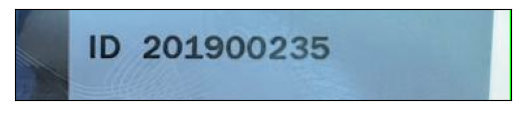

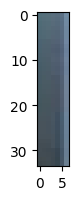

(34, 7)


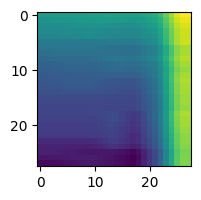

l


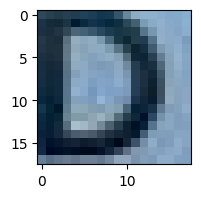

(18, 18)


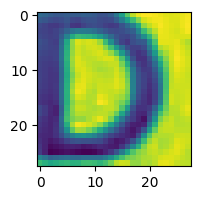

J


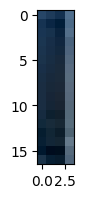

(17, 4)


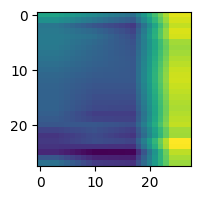

i
Image done



Section Done








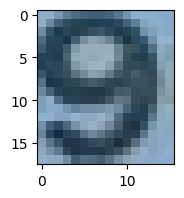

(18, 16)


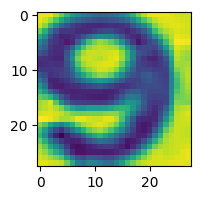

J


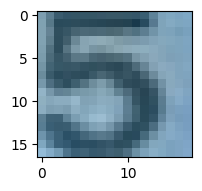

(17, 18)


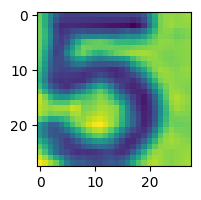

3


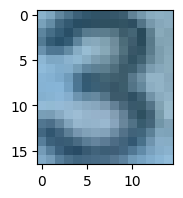

(17, 15)


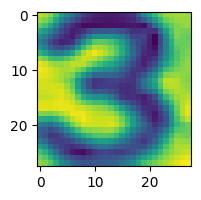

3


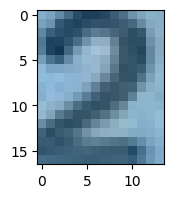

(17, 14)


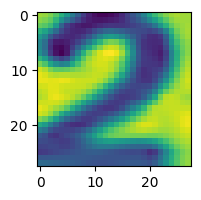

7


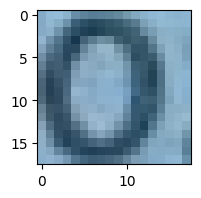

(18, 18)


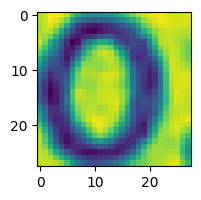

J


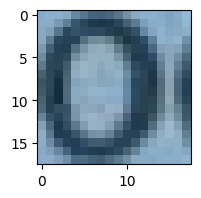

(18, 18)


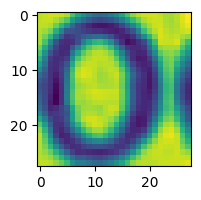

D


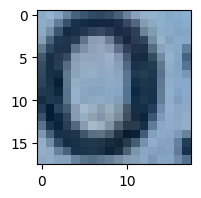

(18, 18)


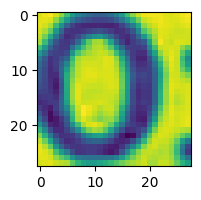

J


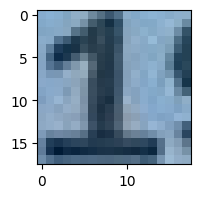

(18, 18)


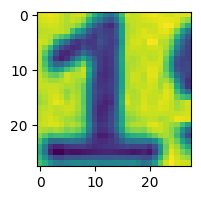

1


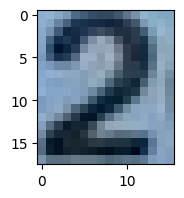

(18, 16)


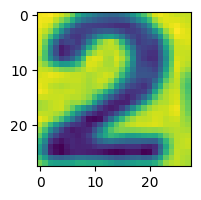

2
Image done



Section Done








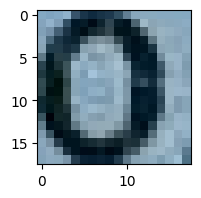

(18, 18)


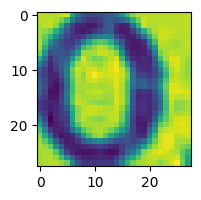

0


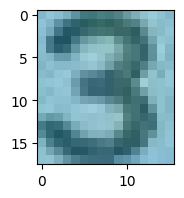

(18, 16)


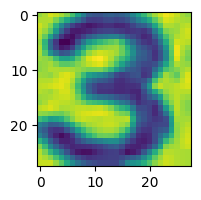

3


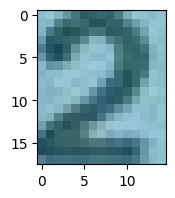

(18, 15)


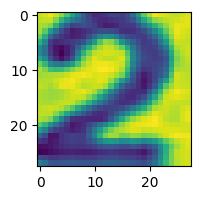

2


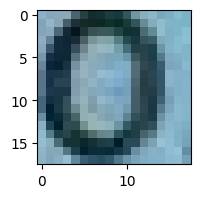

(18, 18)


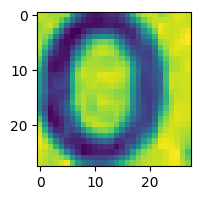

O


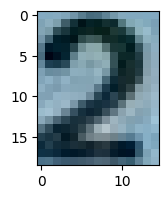

(19, 15)


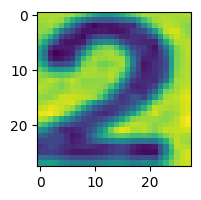

2


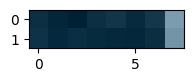

(2, 8)


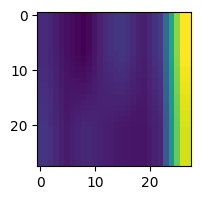

j


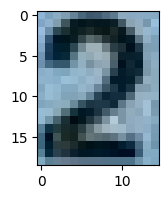

(19, 15)


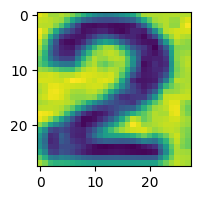

2


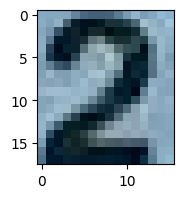

(18, 16)


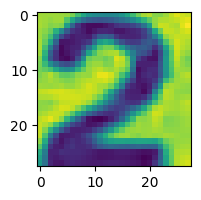

2


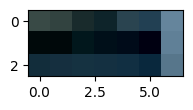

(3, 7)


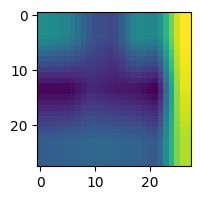

t


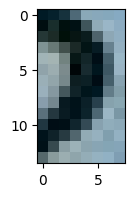

(14, 8)


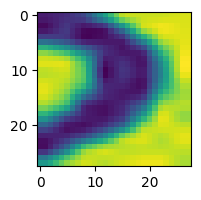

y
Image done



Section Done








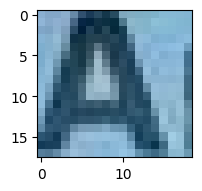

(18, 19)


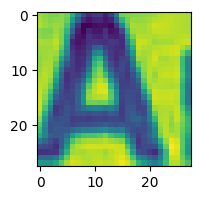

4


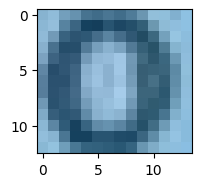

(13, 14)


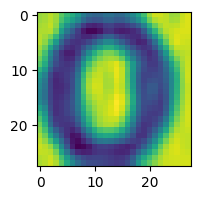

J


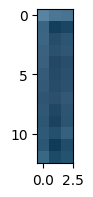

(13, 3)


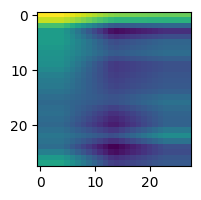

j


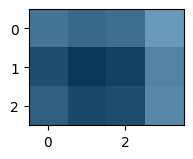

(3, 4)


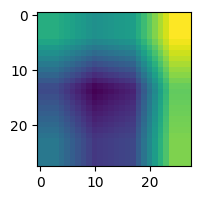

j


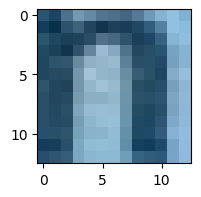

(13, 13)


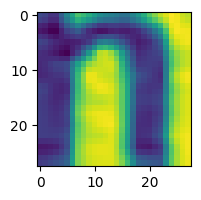

n


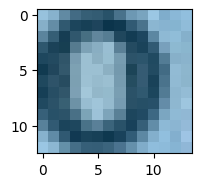

(13, 14)


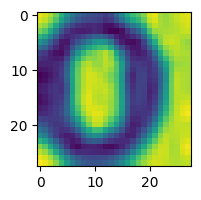

J


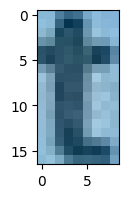

(17, 9)


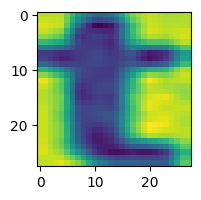

t


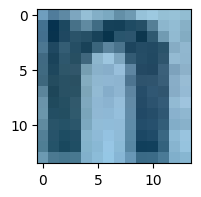

(14, 14)


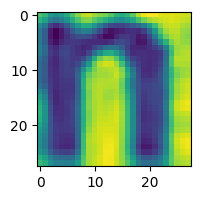

n
Image done



Section Done








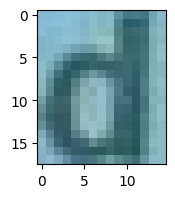

(18, 15)


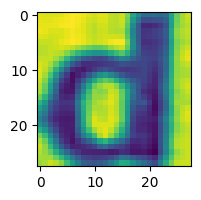

j


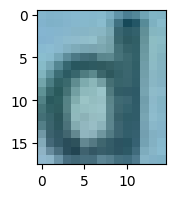

(18, 15)


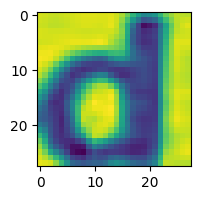

J


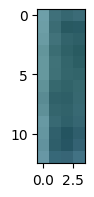

(13, 4)


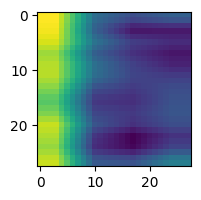

j


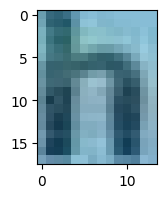

(18, 14)


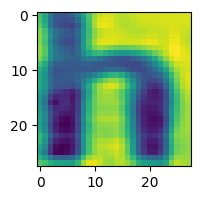

A


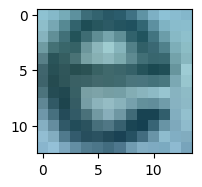

(13, 14)


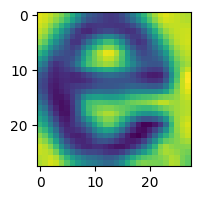

t


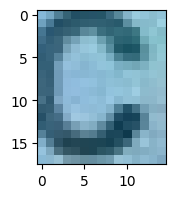

(18, 15)


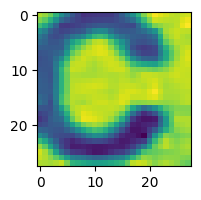

E
Image done



Section Done








In [36]:
path = "./test_2.jpeg"

id_images = get_id(path)
#type_images = get_type(r"./id.png")
type_images = []
year_images = get_year(path)
name_images = get_name(path)
all_images = [id_images, year_images, type_images, name_images]
for t in all_images:
    for image in t:
        chars = extract_single_characters(image)
        for char in chars:
            plt.figure(figsize=(2,2))
            plt.imshow(char)
            plt.show()
            prediction = return_pred_alternate(char)
            print(prediction)
        print("Image done\n\n\n")
        print("Section Done\n\n\n\n\n\n")